# Test 1

### Import

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from backtesting import Backtest
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

/Users/leonanthonymenge/Documents/AKI/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Device

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")

Using device: mps


### Hyperparameter

In [3]:
# Model parameter
input_size = 9
output_size = 1
hidden_size = 10
num_layers = 2
dropout = 0.2

# Training parameter
batch_size = 16
num_epochs = 1
learning_rate = 0.001
seq_size = 10

### LSTM Model

In [4]:
class Net(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(Net, self).__init__()
        self.layer_1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.layer_2 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=dropout, num_layers=num_layers)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.layer_1(x)  
        x = torch.relu(x)

        x, _ = self.layer_2(x)
        x = torch.relu(x)

        x = self.output_layer(x[:, -1, :])  
        
        return x

### Dataloader

In [5]:
class FinanceDataset(Dataset):
    def __init__(self, data_path, seq_size):
        self.data = pd.read_pickle(data_path)
        self.seq_size = seq_size
        
        self.inputs = self.data.iloc[:, 1:-1].values
        self.labels = self.data.iloc[:, -1].values
        
        scaler = MinMaxScaler()
        self.inputs = scaler.fit_transform(self.inputs)

    def __len__(self):
        return len(self.inputs) - self.seq_size

    def __getitem__(self, idx):
        x = self.inputs[idx:idx + self.seq_size]
        y = self.labels[idx + self.seq_size] 

        # Convert to tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        
        return x, y

### Init

In [6]:
# Initialize model, loss function, optimizer
net = Net(input_size, output_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

In [7]:
# Initialize dataset and dataloader
dataset = FinanceDataset('../Data/train_dax_data.pkl', seq_size=seq_size)
train_loader = DataLoader(dataset, batch_size=batch_size)

### Training

In [8]:
losses = []
# Training loop
for epoch in range(num_epochs):
    running_loss = 0
    for inputs, labels in train_loader:
        print(inputs.shape)
        optimizer.zero_grad()
        outputs = net(inputs.float())
        loss = criterion(torch.squeeze(outputs), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Save model after each epoch
    model_path = f'../Models/model-{epoch + 1}.pt'
    torch.save(net.state_dict(), model_path)

    
    if epoch % 10 == 0:
        learning_rate *= 0.8
        optimizer = optim.SGD(net.parameters(), lr=learning_rate)

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')
    losses.append(running_loss / len(train_loader))

torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 10, 9])
torch.Size([16, 

### Backtesting

In [9]:
import pandas as pd
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import numpy as np

net.eval()

# Load your DataFrame
data = pd.read_pickle('../Data/test_dax_data.pkl')

test_data = FinanceDataset('../Data/test_dax_data.pkl', seq_size=seq_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
# Select all rows and columns from index 1 to -1 (exclusive)

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Forward pass through the network
        out = net(inputs)  # The model expects (batch_size, sequence_length, num_features)
        # Store predictions and labels
        all_predictions.append(out.numpy())  # Convert to numpy for easier handling
        all_labels.append(labels.numpy())

# Concatenate results
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)

# Print or analyze the predictions
print(f'Predicted values: {all_predictions.flatten()}')
print(f'Actual values: {all_labels.flatten()}')

# Optionally, save predictions to a CSV file
output_df = pd.DataFrame({'Predicted': all_predictions.flatten(), 'Actual': all_labels.flatten()})


Predicted values: [-0.04587231 -0.04531656 -0.04528955 -0.04552289 -0.04567264 -0.04584087
 -0.04600352 -0.04619579 -0.04633918 -0.04616079 -0.0461214  -0.04611802
 -0.04607139 -0.04584177 -0.04550257 -0.04549797 -0.04552217 -0.04545309
 -0.0456655  -0.04568132 -0.04575668 -0.04585323 -0.04594192 -0.04591908
 -0.04553995 -0.04527301 -0.04509578 -0.0448571  -0.04499862 -0.0451411
 -0.04527105 -0.04548228 -0.04563248 -0.04544565 -0.04528886 -0.04531141
 -0.04531159 -0.04525538 -0.04521177 -0.04527611 -0.04535297 -0.04541322
 -0.04551843 -0.04543003 -0.04540141 -0.04533688 -0.04533889 -0.04548334
 -0.04531117 -0.04529338 -0.04522437 -0.04510532 -0.04521116 -0.04514806
 -0.04502226 -0.04499606 -0.04495221 -0.04480986 -0.04470174 -0.04461982
 -0.0446206  -0.04450126 -0.04436882 -0.04445478 -0.04457105 -0.04460035
 -0.04471143 -0.04461194 -0.04453573 -0.04457325 -0.04459109 -0.044534
 -0.04429504 -0.04416268 -0.0440713  -0.04407819 -0.04411218 -0.04394686
 -0.04391765 -0.04394757 -0.04398791

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

threshold = 0.5
predicted_classes = (all_predictions.flatten() > threshold).astype(int)

accuracy = accuracy_score(all_labels.flatten(), predicted_classes)
precision = precision_score(all_labels.flatten(), predicted_classes)
recall = recall_score(all_labels.flatten(), predicted_classes)
f1 = f1_score(all_labels.flatten(), predicted_classes)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Accuracy: 0.40
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


/Users/leonanthonymenge/Documents/AKI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


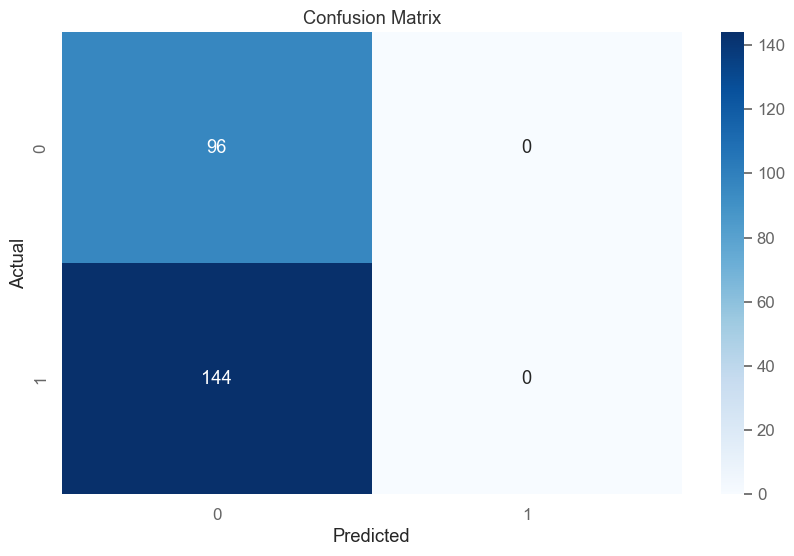

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels.flatten(), predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


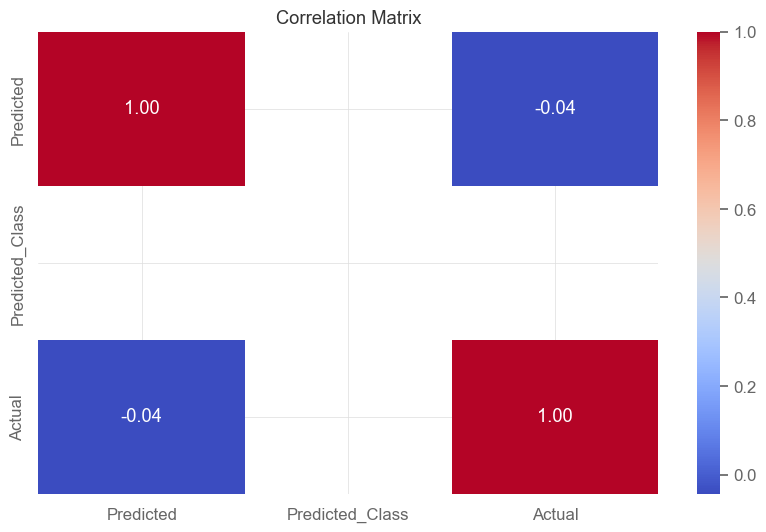

,Predicted,Predicted_Class,Actual
0,-0.045872,0,1.0
1,-0.045317,0,1.0
2,-0.045290,0,1.0
3,-0.045523,0,1.0
4,-0.045673,0,1.0
...,...,...,...
235,-0.040314,0,1.0
236,-0.040378,0,1.0
237,-0.040400,0,0.0
238,-0.040297,0,0.0


In [12]:
output_df = pd.DataFrame({
    'Predicted': all_predictions.flatten(),
    'Predicted_Class': predicted_classes,
    'Actual': all_labels.flatten()
})
correlation_matrix = output_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
display(output_df)

In [15]:
from lumibot.backtesting import YahooDataBacktesting
from datetime import datetime 
from lumibot.brokers import Alpaca
import os
from dotenv import load_dotenv

load_dotenv()

i = 1
model_path = f"/Users/leonanthonymenge/Documents/AKI/Test1/Models/model-{i}.pt"
model = Net(input_size, output_size, hidden_size, num_layers)

# Load state_dict only
model.load_state_dict(torch.load(model_path))  # Do not use weights_only
model.eval()

ALPACA_CREDS = {
    "API_KEY":os.getenv("ALPACA_API_KEY"), 
    "API_SECRET": os.getenv("ALPACA_API_SECRET"), 
    "PAPER": True
}

# Strategy setup
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 12, 31)
broker = Alpaca(ALPACA_CREDS)

# Instantiate and run the strategy
strategy = Backtest(
    name='test1',
    broker=broker,
    parameters={
        "symbol": "DAX",
        "cash_at_risk": 0.5,
        "model": model,
        "num_prior_days": 5
    }
)

strategy.backtest(
    YahooDataBacktesting,
    start_date,
    end_date,
    parameters={"symbol": "DAX", "cash_at_risk": 0.5, "model":model}
)



/var/folders/6x/zpfvcglj30g1jqpb419n03_c0000gn/T/ipykernel_66002/3046578782.py:14: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Starting backtest for Backtest...
Progress ||   0.10%  [Elapsed: 0:00:00 ETA: 0:10:29] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   0.16%  [Elapsed: 0:00:00 ETA: 0:06:30] Portfolio Val: 100,000.00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   0.37%  [Elapsed: 0:00:00 ETA: 0:03:25] Portfolio Val: 100,977.62


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   0.44%  [Elapsed: 0:00:00 ETA: 0:03:16] Portfolio Val: 101,775.38


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   0.51%  [Elapsed: 0:00:00 ETA: 0:03:12] Portfolio Val: 99,740.64


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   0.58%  [Elapsed: 0:00:01 ETA: 0:03:09] Portfolio Val: 98,073.61


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   0.64%  [Elapsed: 0:00:01 ETA: 0:03:08] Portfolio Val: 91,614.97


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   0.85%  [Elapsed: 0:00:01 ETA: 0:02:42] Portfolio Val: 88,409.89

Progress ||   0.85%  [Elapsed: 0:00:01 ETA: 0:02:42] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   0.92%  [Elapsed: 0:00:01 ETA: 0:02:42] Portfolio Val: 104,146.28


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   0.99%  [Elapsed: 0:00:01 ETA: 0:02:42] Portfolio Val: 95,266.33


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   1.05%  [Elapsed: 0:00:01 ETA: 0:02:43] Portfolio Val: 80,981.05


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   1.12%  [Elapsed: 0:00:01 ETA: 0:02:43] Portfolio Val: 72,988.17


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   1.40%  [Elapsed: 0:00:02 ETA: 0:02:21] Portfolio Val: 51,916.79


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   1.47%  [Elapsed: 0:00:02 ETA: 0:02:22] Portfolio Val: 88,111.96


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   1.53%  [Elapsed: 0:00:02 ETA: 0:02:24] Portfolio Val: 142,528.46


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   1.60%  [Elapsed: 0:00:02 ETA: 0:02:24] Portfolio Val: 347,091.29


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   1.67%  [Elapsed: 0:00:02 ETA: 0:02:27] Portfolio Val: -207,444.95

Progress ||   1.81%  [Elapsed: 0:00:02 ETA: 0:02:18] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   1.88%  [Elapsed: 0:00:02 ETA: 0:02:20] Portfolio Val: 1,938,013.68

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   1.94%  [Elapsed: 0:00:02 ETA: 0:02:20] Portfolio Val: 1,938,013.68


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   2.01%  [Elapsed: 0:00:02 ETA: 0:02:22] Portfolio Val: 301,733.12


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   2.08%  [Elapsed: 0:00:03 ETA: 0:02:22] Portfolio Val: 3,312,424.96


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   2.28%  [Elapsed: 0:00:03 ETA: 0:02:16] Portfolio Val: 5,462,415.39

Progress ||   2.29%  [Elapsed: 0:00:03 ETA: 0:02:16] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   2.36%  [Elapsed: 0:00:03 ETA: 0:02:17] Portfolio Val: 8,164,854.71

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   2.42%  [Elapsed: 0:00:03 ETA: 0:02:17] Portfolio Val: -8,955,037.49


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   2.49%  [Elapsed: 0:00:03 ETA: 0:02:20] Portfolio Val: -19,511,271.43


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   2.56%  [Elapsed: 0:00:03 ETA: 0:02:21] Portfolio Val: -35,860,862.74


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   2.77%  [Elapsed: 0:00:03 ETA: 0:02:18] Portfolio Val: -4,291,009.12

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   2.84%  [Elapsed: 0:00:04 ETA: 0:02:19] Portfolio Val: 25,458,314.29

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   2.90%  [Elapsed: 0:00:04 ETA: 0:02:20] Portfolio Val: -43,661,243.23


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   2.97%  [Elapsed: 0:00:04 ETA: 0:02:21] Portfolio Val: -104,494,245.69


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   3.04%  [Elapsed: 0:00:04 ETA: 0:02:21] Portfolio Val: -149,933,901.93


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   3.11%  [Elapsed: 0:00:04 ETA: 0:02:22] Portfolio Val: -109,195,996.86

Progress ||   3.31%  [Elapsed: 0:00:04 ETA: 0:02:16] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   3.38%  [Elapsed: 0:00:04 ETA: 0:02:16] Portfolio Val: 185,597,920.75


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   3.45%  [Elapsed: 0:00:04 ETA: 0:02:17] Portfolio Val: 170,316,544.80


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   3.52%  [Elapsed: 0:00:05 ETA: 0:02:18] Portfolio Val: -242,812,595.16


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   3.59%  [Elapsed: 0:00:05 ETA: 0:02:19] Portfolio Val: 988,163,816.48

Progress ||   3.73%  [Elapsed: 0:00:05 ETA: 0:02:16] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   3.79%  [Elapsed: 0:00:05 ETA: 0:02:16] Portfolio Val: 6,898,480,395.38


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   3.86%  [Elapsed: 0:00:05 ETA: 0:02:19] Portfolio Val: 6,898,480,395.38

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   3.93%  [Elapsed: 0:00:05 ETA: 0:02:19] Portfolio Val: 13,360,337,883.19


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   4.00%  [Elapsed: 0:00:05 ETA: 0:02:20] Portfolio Val: 25,010,901,374.58


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   4.07%  [Elapsed: 0:00:05 ETA: 0:02:20] Portfolio Val: 55,862,421,549.85

Progress ||   4.21%  [Elapsed: 0:00:06 ETA: 0:02:18] 

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   4.27%  [Elapsed: 0:00:06 ETA: 0:02:20] Portfolio Val: 31,020,558,017.34


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   4.34%  [Elapsed: 0:00:06 ETA: 0:02:20] Portfolio Val: -9,843,955,092.20


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   4.41%  [Elapsed: 0:00:06 ETA: 0:02:21] Portfolio Val: 2,233,216,049.87


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   4.48%  [Elapsed: 0:00:06 ETA: 0:02:22] Portfolio Val: 39,177,076,448.33


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   4.55%  [Elapsed: 0:00:06 ETA: 0:02:22] Portfolio Val: 126,359,925,359.86

Progress ||   4.68%  [Elapsed: 0:00:06 ETA: 0:02:20] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   4.75%  [Elapsed: 0:00:07 ETA: 0:02:21] Portfolio Val: 490,155,616,975.05


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   4.82%  [Elapsed: 0:00:07 ETA: 0:02:22] Portfolio Val: 811,739,109,775.05

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   4.89%  [Elapsed: 0:00:07 ETA: 0:02:23] Portfolio Val: 2,371,690,154,787.22

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   4.96%  [Elapsed: 0:00:07 ETA: 0:02:23] Portfolio Val: 2,172,765,773,371.53


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   5.16%  [Elapsed: 0:00:07 ETA: 0:02:19] Portfolio Val: 2,172,765,773,371.53


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   5.23%  [Elapsed: 0:00:07 ETA: 0:02:19] Portfolio Val: 6,817,578,953,093.55


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   5.30%  [Elapsed: 0:00:07 ETA: 0:02:19] Portfolio Val: 8,212,967,270,770.61


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   5.37%  [Elapsed: 0:00:07 ETA: 0:02:19] Portfolio Val: 9,787,843,098,658.73


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   5.44%  [Elapsed: 0:00:08 ETA: 0:02:20] Portfolio Val: 4,830,711,899,830.72


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   5.64%  [Elapsed: 0:00:08 ETA: 0:02:17] Portfolio Val: 4,735,933,946,748.47


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   5.71%  [Elapsed: 0:00:08 ETA: 0:02:17] Portfolio Val: -7,910,281,218,737.34


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   5.78%  [Elapsed: 0:00:08 ETA: 0:02:17] Portfolio Val: -9,340,084,942,802.23


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   5.85%  [Elapsed: 0:00:08 ETA: 0:02:18] Portfolio Val: -10,466,685,248,232.25

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   5.91%  [Elapsed: 0:00:08 ETA: 0:02:18] Portfolio Val: -10,499,495,364,849.00


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   5.98%  [Elapsed: 0:00:08 ETA: 0:02:19] Portfolio Val: -10,499,495,364,849.00

Progress ||   6.12%  [Elapsed: 0:00:08 ETA: 0:02:16] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   6.19%  [Elapsed: 0:00:09 ETA: 0:02:16] Portfolio Val: -12,772,085,104,900.56


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   6.26%  [Elapsed: 0:00:09 ETA: 0:02:16] Portfolio Val: -6,322,558,567,763.70


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   6.33%  [Elapsed: 0:00:09 ETA: 0:02:17] Portfolio Val: -9,541,410,309,332.16


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   6.39%  [Elapsed: 0:00:09 ETA: 0:02:16] Portfolio Val: -4,356,489,819,289.94


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   6.60%  [Elapsed: 0:00:09 ETA: 0:02:14] Portfolio Val: -4,356,489,819,289.94


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   6.67%  [Elapsed: 0:00:09 ETA: 0:02:15] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   6.74%  [Elapsed: 0:00:09 ETA: 0:02:16] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   6.81%  [Elapsed: 0:00:09 ETA: 0:02:16] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   7.08%  [Elapsed: 0:00:10 ETA: 0:02:12] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   7.15%  [Elapsed: 0:00:10 ETA: 0:02:12] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   7.22%  [Elapsed: 0:00:10 ETA: 0:02:12] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   7.28%  [Elapsed: 0:00:10 ETA: 0:02:12] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   7.35%  [Elapsed: 0:00:10 ETA: 0:02:12] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   7.56%  [Elapsed: 0:00:10 ETA: 0:02:10] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   7.63%  [Elapsed: 0:00:10 ETA: 0:02:10] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   7.70%  [Elapsed: 0:00:10 ETA: 0:02:10] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   7.76%  [Elapsed: 0:00:11 ETA: 0:02:10] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   7.83%  [Elapsed: 0:00:11 ETA: 0:02:11] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   8.04%  [Elapsed: 0:00:11 ETA: 0:02:08] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   8.11%  [Elapsed: 0:00:11 ETA: 0:02:08] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   8.17%  [Elapsed: 0:00:11 ETA: 0:02:09] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   8.24%  [Elapsed: 0:00:11 ETA: 0:02:08] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   8.31%  [Elapsed: 0:00:11 ETA: 0:02:08] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   8.52%  [Elapsed: 0:00:11 ETA: 0:02:06] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   8.59%  [Elapsed: 0:00:11 ETA: 0:02:06] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   8.65%  [Elapsed: 0:00:12 ETA: 0:02:06] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   8.72%  [Elapsed: 0:00:12 ETA: 0:02:06] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   8.79%  [Elapsed: 0:00:12 ETA: 0:02:07] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   9.00%  [Elapsed: 0:00:12 ETA: 0:02:05] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   9.07%  [Elapsed: 0:00:12 ETA: 0:02:05] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   9.13%  [Elapsed: 0:00:12 ETA: 0:02:05] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   9.20%  [Elapsed: 0:00:12 ETA: 0:02:05] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   9.27%  [Elapsed: 0:00:12 ETA: 0:02:05] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   9.48%  [Elapsed: 0:00:12 ETA: 0:02:03] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   9.54%  [Elapsed: 0:00:13 ETA: 0:02:03] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   9.61%  [Elapsed: 0:00:13 ETA: 0:02:04] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   9.68%  [Elapsed: 0:00:13 ETA: 0:02:05] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||   9.75%  [Elapsed: 0:00:13 ETA: 0:02:04] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  10.02%  [Elapsed: 0:00:13 ETA: 0:02:02] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  10.09%  [Elapsed: 0:00:13 ETA: 0:02:02] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  10.16%  [Elapsed: 0:00:13 ETA: 0:02:02] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  10.23%  [Elapsed: 0:00:13 ETA: 0:02:02] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  10.44%  [Elapsed: 0:00:14 ETA: 0:02:00] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  10.50%  [Elapsed: 0:00:14 ETA: 0:02:00] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  10.57%  [Elapsed: 0:00:14 ETA: 0:02:00] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  10.64%  [Elapsed: 0:00:14 ETA: 0:02:01] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  10.71%  [Elapsed: 0:00:14 ETA: 0:02:01] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  10.91%  [Elapsed: 0:00:14 ETA: 0:01:59] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  10.98%  [Elapsed: 0:00:14 ETA: 0:01:59] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  11.05%  [Elapsed: 0:00:15 ETA: 0:02:01] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  11.12%  [Elapsed: 0:00:15 ETA: 0:02:01] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  11.19%  [Elapsed: 0:00:15 ETA: 0:02:01] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  11.39%  [Elapsed: 0:00:15 ETA: 0:02:00] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  11.46%  [Elapsed: 0:00:15 ETA: 0:02:00] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  11.53%  [Elapsed: 0:00:15 ETA: 0:02:00] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  11.60%  [Elapsed: 0:00:15 ETA: 0:02:00] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  11.67%  [Elapsed: 0:00:15 ETA: 0:02:00] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  11.87%  [Elapsed: 0:00:16 ETA: 0:01:58] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  11.94%  [Elapsed: 0:00:16 ETA: 0:01:58] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  12.01%  [Elapsed: 0:00:16 ETA: 0:01:58] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  12.08%  [Elapsed: 0:00:16 ETA: 0:01:58] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  12.15%  [Elapsed: 0:00:16 ETA: 0:01:58] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  12.35%  [Elapsed: 0:00:16 ETA: 0:01:57] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  12.42%  [Elapsed: 0:00:16 ETA: 0:01:57] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  12.49%  [Elapsed: 0:00:16 ETA: 0:01:57] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  12.56%  [Elapsed: 0:00:16 ETA: 0:01:57] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  12.83%  [Elapsed: 0:00:16 ETA: 0:01:55] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  12.90%  [Elapsed: 0:00:17 ETA: 0:01:55] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  12.97%  [Elapsed: 0:00:17 ETA: 0:01:55] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  13.04%  [Elapsed: 0:00:17 ETA: 0:01:55] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  13.11%  [Elapsed: 0:00:17 ETA: 0:01:56] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  13.31%  [Elapsed: 0:00:17 ETA: 0:01:54] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  13.38%  [Elapsed: 0:00:17 ETA: 0:01:54] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  13.45%  [Elapsed: 0:00:17 ETA: 0:01:54] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  13.52%  [Elapsed: 0:00:17 ETA: 0:01:54] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  13.59%  [Elapsed: 0:00:18 ETA: 0:01:54] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  13.79%  [Elapsed: 0:00:18 ETA: 0:01:53] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  13.86%  [Elapsed: 0:00:18 ETA: 0:01:53] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  13.93%  [Elapsed: 0:00:18 ETA: 0:01:53] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  14.00%  [Elapsed: 0:00:18 ETA: 0:01:53] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  14.07%  [Elapsed: 0:00:18 ETA: 0:01:53] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  14.27%  [Elapsed: 0:00:18 ETA: 0:01:52] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  14.34%  [Elapsed: 0:00:18 ETA: 0:01:52] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  14.41%  [Elapsed: 0:00:18 ETA: 0:01:52] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  14.48%  [Elapsed: 0:00:18 ETA: 0:01:52] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  14.54%  [Elapsed: 0:00:19 ETA: 0:01:52] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  14.75%  [Elapsed: 0:00:19 ETA: 0:01:51] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  14.82%  [Elapsed: 0:00:19 ETA: 0:01:51] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  14.89%  [Elapsed: 0:00:19 ETA: 0:01:51] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  14.96%  [Elapsed: 0:00:19 ETA: 0:01:51] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  15.02%  [Elapsed: 0:00:19 ETA: 0:01:51] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  15.23%  [Elapsed: 0:00:19 ETA: 0:01:50] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  15.30%  [Elapsed: 0:00:19 ETA: 0:01:50] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  15.37%  [Elapsed: 0:00:20 ETA: 0:01:50] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  15.44%  [Elapsed: 0:00:20 ETA: 0:01:50] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  15.50%  [Elapsed: 0:00:20 ETA: 0:01:50] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  15.71%  [Elapsed: 0:00:20 ETA: 0:01:49] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  15.78%  [Elapsed: 0:00:20 ETA: 0:01:49] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  15.85%  [Elapsed: 0:00:20 ETA: 0:01:49] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  15.91%  [Elapsed: 0:00:20 ETA: 0:01:49] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  15.98%  [Elapsed: 0:00:20 ETA: 0:01:49] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


[*********************100%%**********************]  1 of 1 completed


X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  16.19%  [Elapsed: 0:00:20 ETA: 0:01:48] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  16.26%  [Elapsed: 0:00:21 ETA: 0:01:48] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  16.33%  [Elapsed: 0:00:21 ETA: 0:01:48] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  16.39%  [Elapsed: 0:00:21 ETA: 0:01:48] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  16.46%  [Elapsed: 0:00:21 ETA: 0:01:48] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  16.67%  [Elapsed: 0:00:21 ETA: 0:01:47] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  16.69%  [Elapsed: 0:00:21 ETA: 0:01:47] Portfolio Val: -73,178,830,703,799.06

Progress ||  16.74%  [Elapsed: 0:00:21 ETA: 0:01:47] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  16.81%  [Elapsed: 0:00:21 ETA: 0:01:47] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  16.87%  [Elapsed: 0:00:21 ETA: 0:01:47] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  16.94%  [Elapsed: 0:00:21 ETA: 0:01:47] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  17.22%  [Elapsed: 0:00:22 ETA: 0:01:45] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  17.28%  [Elapsed: 0:00:22 ETA: 0:01:45] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  17.35%  [Elapsed: 0:00:22 ETA: 0:01:45] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  17.42%  [Elapsed: 0:00:22 ETA: 0:01:45] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  17.63%  [Elapsed: 0:00:22 ETA: 0:01:44] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  17.70%  [Elapsed: 0:00:22 ETA: 0:01:45] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  17.76%  [Elapsed: 0:00:22 ETA: 0:01:45] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  17.83%  [Elapsed: 0:00:22 ETA: 0:01:45] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  17.90%  [Elapsed: 0:00:22 ETA: 0:01:45] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  18.11%  [Elapsed: 0:00:23 ETA: 0:01:44] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  18.17%  [Elapsed: 0:00:23 ETA: 0:01:44] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  18.24%  [Elapsed: 0:00:23 ETA: 0:01:44] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  18.31%  [Elapsed: 0:00:23 ETA: 0:01:44] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  18.38%  [Elapsed: 0:00:23 ETA: 0:01:44] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  18.59%  [Elapsed: 0:00:23 ETA: 0:01:43] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  18.65%  [Elapsed: 0:00:23 ETA: 0:01:43] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  18.72%  [Elapsed: 0:00:23 ETA: 0:01:43] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  18.79%  [Elapsed: 0:00:23 ETA: 0:01:43] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  18.86%  [Elapsed: 0:00:24 ETA: 0:01:43] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  19.06%  [Elapsed: 0:00:24 ETA: 0:01:42] Portfolio Val: -73,178,830,703,799.06

Progress ||  19.07%  [Elapsed: 0:00:24 ETA: 0:01:42] 

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  19.13%  [Elapsed: 0:00:24 ETA: 0:01:42] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  19.20%  [Elapsed: 0:00:24 ETA: 0:01:42] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  19.27%  [Elapsed: 0:00:24 ETA: 0:01:42] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  19.34%  [Elapsed: 0:00:24 ETA: 0:01:42] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  19.54%  [Elapsed: 0:00:24 ETA: 0:01:41] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  19.61%  [Elapsed: 0:00:24 ETA: 0:01:41] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  19.68%  [Elapsed: 0:00:24 ETA: 0:01:41] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  19.70%  [Elapsed: 0:00:25 ETA: 0:01:42] Portfolio Val: -73,178,830,703,799.06

Progress ||  19.75%  [Elapsed: 0:00:25 ETA: 0:01:41] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  19.82%  [Elapsed: 0:00:25 ETA: 0:01:41] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  20.02%  [Elapsed: 0:00:25 ETA: 0:01:41] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  20.09%  [Elapsed: 0:00:25 ETA: 0:01:41] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  20.16%  [Elapsed: 0:00:25 ETA: 0:01:41] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  20.23%  [Elapsed: 0:00:25 ETA: 0:01:41] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  20.30%  [Elapsed: 0:00:25 ETA: 0:01:41] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  20.50%  [Elapsed: 0:00:25 ETA: 0:01:40] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  20.57%  [Elapsed: 0:00:25 ETA: 0:01:40] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  20.64%  [Elapsed: 0:00:26 ETA: 0:01:40] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  20.71%  [Elapsed: 0:00:26 ETA: 0:01:40] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  20.78%  [Elapsed: 0:00:26 ETA: 0:01:40] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  20.99%  [Elapsed: 0:00:26 ETA: 0:01:39] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  21.05%  [Elapsed: 0:00:26 ETA: 0:01:39] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  21.12%  [Elapsed: 0:00:26 ETA: 0:01:39] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  21.19%  [Elapsed: 0:00:26 ETA: 0:01:39] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  21.26%  [Elapsed: 0:00:26 ETA: 0:01:39] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  21.47%  [Elapsed: 0:00:26 ETA: 0:01:38] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  21.53%  [Elapsed: 0:00:27 ETA: 0:01:38] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  21.60%  [Elapsed: 0:00:27 ETA: 0:01:38] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  21.67%  [Elapsed: 0:00:27 ETA: 0:01:38] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  21.74%  [Elapsed: 0:00:27 ETA: 0:01:38] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  21.94%  [Elapsed: 0:00:27 ETA: 0:01:37] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  22.01%  [Elapsed: 0:00:27 ETA: 0:01:37] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  22.08%  [Elapsed: 0:00:27 ETA: 0:01:37] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  22.15%  [Elapsed: 0:00:27 ETA: 0:01:38] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  22.22%  [Elapsed: 0:00:27 ETA: 0:01:37] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  22.42%  [Elapsed: 0:00:28 ETA: 0:01:37] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  22.49%  [Elapsed: 0:00:28 ETA: 0:01:37] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  22.56%  [Elapsed: 0:00:28 ETA: 0:01:37] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  22.70%  [Elapsed: 0:00:28 ETA: 0:01:36] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  22.90%  [Elapsed: 0:00:28 ETA: 0:01:36] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  22.97%  [Elapsed: 0:00:28 ETA: 0:01:36] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  23.04%  [Elapsed: 0:00:28 ETA: 0:01:36] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  23.11%  [Elapsed: 0:00:28 ETA: 0:01:36] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  23.18%  [Elapsed: 0:00:28 ETA: 0:01:36] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  23.38%  [Elapsed: 0:00:29 ETA: 0:01:35] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  23.45%  [Elapsed: 0:00:29 ETA: 0:01:35] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  23.52%  [Elapsed: 0:00:29 ETA: 0:01:35] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  23.59%  [Elapsed: 0:00:29 ETA: 0:01:35] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  23.66%  [Elapsed: 0:00:29 ETA: 0:01:35] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  23.86%  [Elapsed: 0:00:29 ETA: 0:01:34] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  23.93%  [Elapsed: 0:00:29 ETA: 0:01:34] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  24.00%  [Elapsed: 0:00:29 ETA: 0:01:34] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  24.07%  [Elapsed: 0:00:29 ETA: 0:01:34] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  24.14%  [Elapsed: 0:00:30 ETA: 0:01:34] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  24.34%  [Elapsed: 0:00:30 ETA: 0:01:33] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  24.41%  [Elapsed: 0:00:30 ETA: 0:01:33] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  24.48%  [Elapsed: 0:00:30 ETA: 0:01:33] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  24.55%  [Elapsed: 0:00:30 ETA: 0:01:33] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  24.82%  [Elapsed: 0:00:30 ETA: 0:01:32] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  24.89%  [Elapsed: 0:00:30 ETA: 0:01:32] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  24.96%  [Elapsed: 0:00:30 ETA: 0:01:32] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  25.03%  [Elapsed: 0:00:30 ETA: 0:01:32] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  25.30%  [Elapsed: 0:00:31 ETA: 0:01:31] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  25.37%  [Elapsed: 0:00:31 ETA: 0:01:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  25.44%  [Elapsed: 0:00:31 ETA: 0:01:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  25.51%  [Elapsed: 0:00:31 ETA: 0:01:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  25.58%  [Elapsed: 0:00:31 ETA: 0:01:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  25.78%  [Elapsed: 0:00:31 ETA: 0:01:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  25.85%  [Elapsed: 0:00:31 ETA: 0:01:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  25.92%  [Elapsed: 0:00:31 ETA: 0:01:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  25.99%  [Elapsed: 0:00:32 ETA: 0:01:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  26.05%  [Elapsed: 0:00:32 ETA: 0:01:31] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  26.33%  [Elapsed: 0:00:32 ETA: 0:01:30] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  26.40%  [Elapsed: 0:00:32 ETA: 0:01:30] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  26.47%  [Elapsed: 0:00:32 ETA: 0:01:30] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  26.53%  [Elapsed: 0:00:32 ETA: 0:01:30] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  26.60%  [Elapsed: 0:00:32 ETA: 0:01:30] Portfolio Val: -73,178,830,703,799.06

Progress ||  26.74%  [Elapsed: 0:00:32 ETA: 0:01:30] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  26.81%  [Elapsed: 0:00:32 ETA: 0:01:30] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  26.88%  [Elapsed: 0:00:33 ETA: 0:01:29] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  26.94%  [Elapsed: 0:00:33 ETA: 0:01:29] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  27.01%  [Elapsed: 0:00:33 ETA: 0:01:29] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  27.22%  [Elapsed: 0:00:33 ETA: 0:01:29] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  27.29%  [Elapsed: 0:00:33 ETA: 0:01:29] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  27.36%  [Elapsed: 0:00:33 ETA: 0:01:29] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  27.42%  [Elapsed: 0:00:33 ETA: 0:01:29] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  27.49%  [Elapsed: 0:00:33 ETA: 0:01:29] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  27.70%  [Elapsed: 0:00:33 ETA: 0:01:28] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  27.77%  [Elapsed: 0:00:34 ETA: 0:01:28] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  27.84%  [Elapsed: 0:00:34 ETA: 0:01:28] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  27.90%  [Elapsed: 0:00:34 ETA: 0:01:28] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  27.97%  [Elapsed: 0:00:34 ETA: 0:01:28] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  28.25%  [Elapsed: 0:00:34 ETA: 0:01:27] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  28.31%  [Elapsed: 0:00:34 ETA: 0:01:27] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  28.38%  [Elapsed: 0:00:34 ETA: 0:01:27] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  28.45%  [Elapsed: 0:00:34 ETA: 0:01:27] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  28.66%  [Elapsed: 0:00:35 ETA: 0:01:27] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  28.73%  [Elapsed: 0:00:35 ETA: 0:01:27] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  28.79%  [Elapsed: 0:00:35 ETA: 0:01:27] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  28.81%  [Elapsed: 0:00:35 ETA: 0:01:27] Portfolio Val: -73,178,830,703,799.06

Progress ||  28.86%  [Elapsed: 0:00:35 ETA: 0:01:27] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  28.93%  [Elapsed: 0:00:35 ETA: 0:01:27] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  29.14%  [Elapsed: 0:00:35 ETA: 0:01:26] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  29.21%  [Elapsed: 0:00:35 ETA: 0:01:26] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  29.27%  [Elapsed: 0:00:35 ETA: 0:01:26] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  29.34%  [Elapsed: 0:00:35 ETA: 0:01:26] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  29.41%  [Elapsed: 0:00:35 ETA: 0:01:26] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  29.62%  [Elapsed: 0:00:36 ETA: 0:01:25] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  29.68%  [Elapsed: 0:00:36 ETA: 0:01:25] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  29.75%  [Elapsed: 0:00:36 ETA: 0:01:25] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  29.82%  [Elapsed: 0:00:36 ETA: 0:01:25] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  29.89%  [Elapsed: 0:00:36 ETA: 0:01:25] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  30.09%  [Elapsed: 0:00:36 ETA: 0:01:24] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  30.16%  [Elapsed: 0:00:36 ETA: 0:01:24] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  30.23%  [Elapsed: 0:00:36 ETA: 0:01:25] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  30.30%  [Elapsed: 0:00:36 ETA: 0:01:25] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  30.37%  [Elapsed: 0:00:37 ETA: 0:01:24] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  30.57%  [Elapsed: 0:00:37 ETA: 0:01:24] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  30.64%  [Elapsed: 0:00:37 ETA: 0:01:24] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  30.71%  [Elapsed: 0:00:37 ETA: 0:01:24] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  30.78%  [Elapsed: 0:00:37 ETA: 0:01:24] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  30.85%  [Elapsed: 0:00:37 ETA: 0:01:24] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  31.05%  [Elapsed: 0:00:37 ETA: 0:01:23] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  31.12%  [Elapsed: 0:00:37 ETA: 0:01:23] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  31.19%  [Elapsed: 0:00:37 ETA: 0:01:23] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  31.26%  [Elapsed: 0:00:38 ETA: 0:01:23] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  31.33%  [Elapsed: 0:00:38 ETA: 0:01:23] Portfolio Val: -73,178,830,703,799.06

Progress ||  31.53%  [Elapsed: 0:00:38 ETA: 0:01:22] 

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  31.60%  [Elapsed: 0:00:38 ETA: 0:01:22] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  31.67%  [Elapsed: 0:00:38 ETA: 0:01:22] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  31.74%  [Elapsed: 0:00:38 ETA: 0:01:22] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  31.81%  [Elapsed: 0:00:38 ETA: 0:01:22] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  32.01%  [Elapsed: 0:00:38 ETA: 0:01:22] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  32.08%  [Elapsed: 0:00:38 ETA: 0:01:22] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  32.15%  [Elapsed: 0:00:38 ETA: 0:01:22] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  32.22%  [Elapsed: 0:00:38 ETA: 0:01:22] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  32.28%  [Elapsed: 0:00:39 ETA: 0:01:22] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  32.49%  [Elapsed: 0:00:39 ETA: 0:01:21] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  32.56%  [Elapsed: 0:00:39 ETA: 0:01:21] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  32.63%  [Elapsed: 0:00:39 ETA: 0:01:21] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  32.65%  [Elapsed: 0:00:39 ETA: 0:01:21] Portfolio Val: -73,178,830,703,799.06

Progress ||  32.70%  [Elapsed: 0:00:39 ETA: 0:01:21] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  32.76%  [Elapsed: 0:00:39 ETA: 0:01:21] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  32.97%  [Elapsed: 0:00:39 ETA: 0:01:20] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  33.04%  [Elapsed: 0:00:39 ETA: 0:01:20] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  33.11%  [Elapsed: 0:00:39 ETA: 0:01:20] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  33.17%  [Elapsed: 0:00:40 ETA: 0:01:20] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  33.24%  [Elapsed: 0:00:40 ETA: 0:01:20] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  33.45%  [Elapsed: 0:00:40 ETA: 0:01:20] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  33.52%  [Elapsed: 0:00:40 ETA: 0:01:20] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  33.59%  [Elapsed: 0:00:40 ETA: 0:01:20] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  33.65%  [Elapsed: 0:00:40 ETA: 0:01:20] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  33.72%  [Elapsed: 0:00:40 ETA: 0:01:20] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  33.93%  [Elapsed: 0:00:40 ETA: 0:01:19] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  34.00%  [Elapsed: 0:00:41 ETA: 0:01:19] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  34.07%  [Elapsed: 0:00:41 ETA: 0:01:19] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  34.13%  [Elapsed: 0:00:41 ETA: 0:01:19] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  34.20%  [Elapsed: 0:00:41 ETA: 0:01:19] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  34.41%  [Elapsed: 0:00:41 ETA: 0:01:18] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  34.48%  [Elapsed: 0:00:41 ETA: 0:01:18] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  34.54%  [Elapsed: 0:00:41 ETA: 0:01:18] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  34.61%  [Elapsed: 0:00:42 ETA: 0:01:19] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  34.68%  [Elapsed: 0:00:42 ETA: 0:01:19] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  34.89%  [Elapsed: 0:00:42 ETA: 0:01:19] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  34.96%  [Elapsed: 0:00:42 ETA: 0:01:19] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  35.02%  [Elapsed: 0:00:42 ETA: 0:01:19] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  35.09%  [Elapsed: 0:00:42 ETA: 0:01:19] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  35.16%  [Elapsed: 0:00:42 ETA: 0:01:18] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  35.44%  [Elapsed: 0:00:42 ETA: 0:01:18] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  35.50%  [Elapsed: 0:00:43 ETA: 0:01:18] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  35.57%  [Elapsed: 0:00:43 ETA: 0:01:18] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  35.64%  [Elapsed: 0:00:43 ETA: 0:01:18] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  35.85%  [Elapsed: 0:00:43 ETA: 0:01:17] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  35.91%  [Elapsed: 0:00:43 ETA: 0:01:17] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  35.98%  [Elapsed: 0:00:43 ETA: 0:01:17] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  36.05%  [Elapsed: 0:00:43 ETA: 0:01:17] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  36.12%  [Elapsed: 0:00:43 ETA: 0:01:17] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  36.33%  [Elapsed: 0:00:44 ETA: 0:01:17] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  36.39%  [Elapsed: 0:00:44 ETA: 0:01:17] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  36.46%  [Elapsed: 0:00:44 ETA: 0:01:17] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  36.53%  [Elapsed: 0:00:44 ETA: 0:01:17] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  36.60%  [Elapsed: 0:00:44 ETA: 0:01:17] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  36.81%  [Elapsed: 0:00:44 ETA: 0:01:16] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  36.87%  [Elapsed: 0:00:44 ETA: 0:01:16] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  36.94%  [Elapsed: 0:00:44 ETA: 0:01:16] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  37.01%  [Elapsed: 0:00:44 ETA: 0:01:16] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  37.08%  [Elapsed: 0:00:45 ETA: 0:01:16] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  37.28%  [Elapsed: 0:00:45 ETA: 0:01:15] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  37.35%  [Elapsed: 0:00:45 ETA: 0:01:15] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  37.42%  [Elapsed: 0:00:45 ETA: 0:01:15] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  37.49%  [Elapsed: 0:00:45 ETA: 0:01:15] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  37.56%  [Elapsed: 0:00:45 ETA: 0:01:15] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  37.83%  [Elapsed: 0:00:45 ETA: 0:01:15] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  37.90%  [Elapsed: 0:00:45 ETA: 0:01:15] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  37.97%  [Elapsed: 0:00:45 ETA: 0:01:15] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  38.04%  [Elapsed: 0:00:46 ETA: 0:01:15] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  38.24%  [Elapsed: 0:00:46 ETA: 0:01:14] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  38.31%  [Elapsed: 0:00:46 ETA: 0:01:14] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  38.38%  [Elapsed: 0:00:46 ETA: 0:01:14] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  38.45%  [Elapsed: 0:00:46 ETA: 0:01:14] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  38.52%  [Elapsed: 0:00:46 ETA: 0:01:14] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  38.72%  [Elapsed: 0:00:46 ETA: 0:01:13] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  38.79%  [Elapsed: 0:00:46 ETA: 0:01:13] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  38.86%  [Elapsed: 0:00:46 ETA: 0:01:13] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  38.93%  [Elapsed: 0:00:47 ETA: 0:01:13] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  39.00%  [Elapsed: 0:00:47 ETA: 0:01:13] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  39.20%  [Elapsed: 0:00:47 ETA: 0:01:13] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  39.27%  [Elapsed: 0:00:47 ETA: 0:01:13] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  39.34%  [Elapsed: 0:00:47 ETA: 0:01:13] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  39.41%  [Elapsed: 0:00:47 ETA: 0:01:13] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  39.48%  [Elapsed: 0:00:47 ETA: 0:01:13] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  39.68%  [Elapsed: 0:00:47 ETA: 0:01:12] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  39.75%  [Elapsed: 0:00:47 ETA: 0:01:12] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  39.82%  [Elapsed: 0:00:48 ETA: 0:01:12] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  39.89%  [Elapsed: 0:00:48 ETA: 0:01:12] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  39.96%  [Elapsed: 0:00:48 ETA: 0:01:12] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  40.16%  [Elapsed: 0:00:48 ETA: 0:01:12] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  40.23%  [Elapsed: 0:00:48 ETA: 0:01:12] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  40.30%  [Elapsed: 0:00:48 ETA: 0:01:12] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  40.37%  [Elapsed: 0:00:48 ETA: 0:01:11] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  40.44%  [Elapsed: 0:00:48 ETA: 0:01:11] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  40.64%  [Elapsed: 0:00:49 ETA: 0:01:11] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  40.71%  [Elapsed: 0:00:49 ETA: 0:01:11] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  40.78%  [Elapsed: 0:00:49 ETA: 0:01:11] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  40.85%  [Elapsed: 0:00:49 ETA: 0:01:11] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  40.91%  [Elapsed: 0:00:49 ETA: 0:01:11] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  41.12%  [Elapsed: 0:00:49 ETA: 0:01:11] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  41.19%  [Elapsed: 0:00:49 ETA: 0:01:11] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  41.26%  [Elapsed: 0:00:49 ETA: 0:01:11] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  41.33%  [Elapsed: 0:00:49 ETA: 0:01:10] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  41.39%  [Elapsed: 0:00:50 ETA: 0:01:10] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  41.46%  [Elapsed: 0:00:50 ETA: 0:01:10] Portfolio Val: -73,178,830,703,799.06

Progress ||  41.60%  [Elapsed: 0:00:50 ETA: 0:01:10] 

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  41.67%  [Elapsed: 0:00:50 ETA: 0:01:10] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  41.74%  [Elapsed: 0:00:50 ETA: 0:01:10] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  41.81%  [Elapsed: 0:00:50 ETA: 0:01:10] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  41.87%  [Elapsed: 0:00:50 ETA: 0:01:10] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  42.15%  [Elapsed: 0:00:50 ETA: 0:01:09] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  42.22%  [Elapsed: 0:00:50 ETA: 0:01:09] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  42.28%  [Elapsed: 0:00:50 ETA: 0:01:09] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  42.35%  [Elapsed: 0:00:51 ETA: 0:01:09] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  42.56%  [Elapsed: 0:00:51 ETA: 0:01:09] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  42.63%  [Elapsed: 0:00:51 ETA: 0:01:09] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  42.70%  [Elapsed: 0:00:51 ETA: 0:01:08] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  42.76%  [Elapsed: 0:00:51 ETA: 0:01:08] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  42.83%  [Elapsed: 0:00:51 ETA: 0:01:08] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  43.04%  [Elapsed: 0:00:51 ETA: 0:01:08] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  43.11%  [Elapsed: 0:00:51 ETA: 0:01:08] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  43.17%  [Elapsed: 0:00:52 ETA: 0:01:08] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  43.24%  [Elapsed: 0:00:52 ETA: 0:01:08] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  43.26%  [Elapsed: 0:00:52 ETA: 0:01:08] Portfolio Val: -73,178,830,703,799.06

Progress ||  43.31%  [Elapsed: 0:00:52 ETA: 0:01:08] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  43.38%  [Elapsed: 0:00:52 ETA: 0:01:08] Portfolio Val: -73,178,830,703,799.06

Progress ||  43.52%  [Elapsed: 0:00:52 ETA: 0:01:07] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  43.59%  [Elapsed: 0:00:52 ETA: 0:01:07] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  43.65%  [Elapsed: 0:00:52 ETA: 0:01:07] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  43.72%  [Elapsed: 0:00:52 ETA: 0:01:07] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  43.79%  [Elapsed: 0:00:52 ETA: 0:01:07] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  44.00%  [Elapsed: 0:00:52 ETA: 0:01:07] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  44.07%  [Elapsed: 0:00:52 ETA: 0:01:07] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  44.13%  [Elapsed: 0:00:53 ETA: 0:01:07] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  44.20%  [Elapsed: 0:00:53 ETA: 0:01:07] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  44.27%  [Elapsed: 0:00:53 ETA: 0:01:07] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  44.48%  [Elapsed: 0:00:53 ETA: 0:01:06] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  44.54%  [Elapsed: 0:00:53 ETA: 0:01:06] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  44.61%  [Elapsed: 0:00:53 ETA: 0:01:06] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


[*********************100%%**********************]  1 of 1 completed

X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  44.68%  [Elapsed: 0:00:53 ETA: 0:01:06] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  44.75%  [Elapsed: 0:00:53 ETA: 0:01:06] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  44.96%  [Elapsed: 0:00:53 ETA: 0:01:06] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  45.02%  [Elapsed: 0:00:54 ETA: 0:01:06] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  45.09%  [Elapsed: 0:00:54 ETA: 0:01:06] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  45.16%  [Elapsed: 0:00:54 ETA: 0:01:05] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  45.23%  [Elapsed: 0:00:54 ETA: 0:01:05] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  45.44%  [Elapsed: 0:00:54 ETA: 0:01:05] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  45.50%  [Elapsed: 0:00:54 ETA: 0:01:05] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  45.57%  [Elapsed: 0:00:54 ETA: 0:01:05] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  45.64%  [Elapsed: 0:00:54 ETA: 0:01:05] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  45.71%  [Elapsed: 0:00:54 ETA: 0:01:05] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  45.91%  [Elapsed: 0:00:55 ETA: 0:01:04] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  45.98%  [Elapsed: 0:00:55 ETA: 0:01:04] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  46.05%  [Elapsed: 0:00:55 ETA: 0:01:04] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  46.12%  [Elapsed: 0:00:55 ETA: 0:01:04] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  46.19%  [Elapsed: 0:00:55 ETA: 0:01:04] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  46.40%  [Elapsed: 0:00:55 ETA: 0:01:04] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  46.47%  [Elapsed: 0:00:55 ETA: 0:01:04] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  46.53%  [Elapsed: 0:00:55 ETA: 0:01:04] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  46.60%  [Elapsed: 0:00:55 ETA: 0:01:04] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  46.67%  [Elapsed: 0:00:56 ETA: 0:01:04] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  46.88%  [Elapsed: 0:00:56 ETA: 0:01:03] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  46.94%  [Elapsed: 0:00:56 ETA: 0:01:03] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  47.01%  [Elapsed: 0:00:56 ETA: 0:01:03] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  47.08%  [Elapsed: 0:00:56 ETA: 0:01:03] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  47.15%  [Elapsed: 0:00:56 ETA: 0:01:03] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  47.36%  [Elapsed: 0:00:56 ETA: 0:01:03] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  47.42%  [Elapsed: 0:00:56 ETA: 0:01:02] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  47.49%  [Elapsed: 0:00:56 ETA: 0:01:02] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  47.63%  [Elapsed: 0:00:57 ETA: 0:01:02] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  47.84%  [Elapsed: 0:00:57 ETA: 0:01:02] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  47.90%  [Elapsed: 0:00:57 ETA: 0:01:02] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  47.97%  [Elapsed: 0:00:57 ETA: 0:01:02] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  48.04%  [Elapsed: 0:00:57 ETA: 0:01:02] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  48.11%  [Elapsed: 0:00:57 ETA: 0:01:02] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  48.31%  [Elapsed: 0:00:57 ETA: 0:01:01] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  48.38%  [Elapsed: 0:00:57 ETA: 0:01:01] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  48.45%  [Elapsed: 0:00:57 ETA: 0:01:01] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  48.52%  [Elapsed: 0:00:58 ETA: 0:01:01] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  48.59%  [Elapsed: 0:00:58 ETA: 0:01:01] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  48.79%  [Elapsed: 0:00:58 ETA: 0:01:01] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  48.86%  [Elapsed: 0:00:58 ETA: 0:01:01] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  48.93%  [Elapsed: 0:00:58 ETA: 0:01:01] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  49.00%  [Elapsed: 0:00:58 ETA: 0:01:01] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  49.07%  [Elapsed: 0:00:58 ETA: 0:01:00] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  49.27%  [Elapsed: 0:00:58 ETA: 0:01:00] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  49.34%  [Elapsed: 0:00:58 ETA: 0:01:00] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  49.41%  [Elapsed: 0:00:59 ETA: 0:01:00] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  49.48%  [Elapsed: 0:00:59 ETA: 0:01:00] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  49.75%  [Elapsed: 0:00:59 ETA: 0:00:59] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  49.82%  [Elapsed: 0:00:59 ETA: 0:00:59] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  49.89%  [Elapsed: 0:00:59 ETA: 0:00:59] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  49.96%  [Elapsed: 0:00:59 ETA: 0:00:59] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  50.03%  [Elapsed: 0:00:59 ETA: 0:00:59] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  50.23%  [Elapsed: 0:00:59 ETA: 0:00:59] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  50.30%  [Elapsed: 0:00:59 ETA: 0:00:59] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  50.37%  [Elapsed: 0:00:59 ETA: 0:00:59] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  50.44%  [Elapsed: 0:01:00 ETA: 0:00:58] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  50.51%  [Elapsed: 0:01:00 ETA: 0:00:58] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  50.71%  [Elapsed: 0:01:00 ETA: 0:00:58] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  50.78%  [Elapsed: 0:01:00 ETA: 0:00:58] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  50.85%  [Elapsed: 0:01:00 ETA: 0:00:58] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  50.92%  [Elapsed: 0:01:00 ETA: 0:00:58] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  50.99%  [Elapsed: 0:01:00 ETA: 0:00:58] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  51.26%  [Elapsed: 0:01:00 ETA: 0:00:57] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  51.33%  [Elapsed: 0:01:00 ETA: 0:00:57] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  51.40%  [Elapsed: 0:01:00 ETA: 0:00:57] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  51.47%  [Elapsed: 0:01:01 ETA: 0:00:57] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  51.67%  [Elapsed: 0:01:01 ETA: 0:00:57] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  51.74%  [Elapsed: 0:01:01 ETA: 0:00:57] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  51.81%  [Elapsed: 0:01:01 ETA: 0:00:57] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  51.88%  [Elapsed: 0:01:01 ETA: 0:00:57] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  51.94%  [Elapsed: 0:01:01 ETA: 0:00:56] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  52.15%  [Elapsed: 0:01:01 ETA: 0:00:56] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  52.22%  [Elapsed: 0:01:01 ETA: 0:00:56] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  52.29%  [Elapsed: 0:01:01 ETA: 0:00:56] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  52.36%  [Elapsed: 0:01:02 ETA: 0:00:56] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  52.42%  [Elapsed: 0:01:02 ETA: 0:00:56] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  52.63%  [Elapsed: 0:01:02 ETA: 0:00:56] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  52.70%  [Elapsed: 0:01:02 ETA: 0:00:55] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  52.77%  [Elapsed: 0:01:02 ETA: 0:00:55] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  52.84%  [Elapsed: 0:01:02 ETA: 0:00:55] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  52.90%  [Elapsed: 0:01:02 ETA: 0:00:55] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  52.97%  [Elapsed: 0:01:02 ETA: 0:00:55] Portfolio Val: -73,178,830,703,799.06

Progress ||  53.11%  [Elapsed: 0:01:02 ETA: 0:00:55] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  53.18%  [Elapsed: 0:01:02 ETA: 0:00:55] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  53.25%  [Elapsed: 0:01:03 ETA: 0:00:55] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  53.31%  [Elapsed: 0:01:03 ETA: 0:00:55] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  53.38%  [Elapsed: 0:01:03 ETA: 0:00:55] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  53.66%  [Elapsed: 0:01:03 ETA: 0:00:54] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  53.73%  [Elapsed: 0:01:03 ETA: 0:00:54] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  53.79%  [Elapsed: 0:01:03 ETA: 0:00:54] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  53.86%  [Elapsed: 0:01:03 ETA: 0:00:54] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  54.07%  [Elapsed: 0:01:03 ETA: 0:00:54] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  54.14%  [Elapsed: 0:01:03 ETA: 0:00:54] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  54.21%  [Elapsed: 0:01:04 ETA: 0:00:54] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  54.27%  [Elapsed: 0:01:04 ETA: 0:00:54] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  54.34%  [Elapsed: 0:01:04 ETA: 0:00:54] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  54.55%  [Elapsed: 0:01:04 ETA: 0:00:53] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  54.62%  [Elapsed: 0:01:04 ETA: 0:00:53] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  54.68%  [Elapsed: 0:01:04 ETA: 0:00:53] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  54.75%  [Elapsed: 0:01:04 ETA: 0:00:53] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  54.82%  [Elapsed: 0:01:04 ETA: 0:00:53] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  54.84%  [Elapsed: 0:01:05 ETA: 0:00:53] Portfolio Val: -73,178,830,703,799.06

Progress ||  55.02%  [Elapsed: 0:01:05 ETA: 0:00:53] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  55.09%  [Elapsed: 0:01:05 ETA: 0:00:53] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  55.16%  [Elapsed: 0:01:05 ETA: 0:00:53] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  55.23%  [Elapsed: 0:01:05 ETA: 0:00:52] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  55.30%  [Elapsed: 0:01:05 ETA: 0:00:52] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  55.50%  [Elapsed: 0:01:05 ETA: 0:00:52] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  55.57%  [Elapsed: 0:01:05 ETA: 0:00:52] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  55.64%  [Elapsed: 0:01:05 ETA: 0:00:52] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  55.71%  [Elapsed: 0:01:05 ETA: 0:00:52] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  55.78%  [Elapsed: 0:01:06 ETA: 0:00:52] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  55.85%  [Elapsed: 0:01:06 ETA: 0:00:52] Portfolio Val: -73,178,830,703,799.06

Progress ||  55.98%  [Elapsed: 0:01:06 ETA: 0:00:52] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  56.05%  [Elapsed: 0:01:06 ETA: 0:00:51] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  56.12%  [Elapsed: 0:01:06 ETA: 0:00:51] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  56.19%  [Elapsed: 0:01:06 ETA: 0:00:51] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  56.26%  [Elapsed: 0:01:06 ETA: 0:00:51] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  56.46%  [Elapsed: 0:01:06 ETA: 0:00:51] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  56.53%  [Elapsed: 0:01:06 ETA: 0:00:51] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  56.60%  [Elapsed: 0:01:07 ETA: 0:00:51] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  56.67%  [Elapsed: 0:01:07 ETA: 0:00:51] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  56.74%  [Elapsed: 0:01:07 ETA: 0:00:51] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  56.94%  [Elapsed: 0:01:07 ETA: 0:00:50] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  57.01%  [Elapsed: 0:01:07 ETA: 0:00:50] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  57.08%  [Elapsed: 0:01:07 ETA: 0:00:50] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  57.15%  [Elapsed: 0:01:07 ETA: 0:00:50] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  57.22%  [Elapsed: 0:01:07 ETA: 0:00:50] Portfolio Val: -73,178,830,703,799.06

Progress ||  57.42%  [Elapsed: 0:01:07 ETA: 0:00:50] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  57.49%  [Elapsed: 0:01:08 ETA: 0:00:50] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  57.56%  [Elapsed: 0:01:08 ETA: 0:00:50] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  57.63%  [Elapsed: 0:01:08 ETA: 0:00:50] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  57.70%  [Elapsed: 0:01:08 ETA: 0:00:50] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  57.90%  [Elapsed: 0:01:08 ETA: 0:00:49] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  57.97%  [Elapsed: 0:01:08 ETA: 0:00:49] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  58.04%  [Elapsed: 0:01:08 ETA: 0:00:49] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  58.11%  [Elapsed: 0:01:08 ETA: 0:00:49] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  58.17%  [Elapsed: 0:01:08 ETA: 0:00:49] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  58.38%  [Elapsed: 0:01:09 ETA: 0:00:49] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  58.45%  [Elapsed: 0:01:09 ETA: 0:00:49] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  58.52%  [Elapsed: 0:01:09 ETA: 0:00:49] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  58.59%  [Elapsed: 0:01:09 ETA: 0:00:49] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  58.65%  [Elapsed: 0:01:09 ETA: 0:00:49] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  58.86%  [Elapsed: 0:01:09 ETA: 0:00:48] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  58.93%  [Elapsed: 0:01:09 ETA: 0:00:48] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  59.00%  [Elapsed: 0:01:09 ETA: 0:00:48] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  59.07%  [Elapsed: 0:01:10 ETA: 0:00:48] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  59.13%  [Elapsed: 0:01:10 ETA: 0:00:48] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  59.34%  [Elapsed: 0:01:10 ETA: 0:00:48] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  59.41%  [Elapsed: 0:01:10 ETA: 0:00:48] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  59.48%  [Elapsed: 0:01:10 ETA: 0:00:48] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  59.54%  [Elapsed: 0:01:10 ETA: 0:00:47] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  59.61%  [Elapsed: 0:01:10 ETA: 0:00:47] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  59.82%  [Elapsed: 0:01:10 ETA: 0:00:47] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  59.89%  [Elapsed: 0:01:10 ETA: 0:00:47] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  59.96%  [Elapsed: 0:01:11 ETA: 0:00:47] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  60.02%  [Elapsed: 0:01:11 ETA: 0:00:47] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  60.09%  [Elapsed: 0:01:11 ETA: 0:00:47] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  60.37%  [Elapsed: 0:01:11 ETA: 0:00:46] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  60.44%  [Elapsed: 0:01:11 ETA: 0:00:46] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  60.50%  [Elapsed: 0:01:11 ETA: 0:00:46] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  60.57%  [Elapsed: 0:01:11 ETA: 0:00:46] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  60.78%  [Elapsed: 0:01:11 ETA: 0:00:46] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  60.85%  [Elapsed: 0:01:11 ETA: 0:00:46] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  60.91%  [Elapsed: 0:01:12 ETA: 0:00:46] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  60.98%  [Elapsed: 0:01:12 ETA: 0:00:46] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  61.05%  [Elapsed: 0:01:12 ETA: 0:00:46] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  61.26%  [Elapsed: 0:01:12 ETA: 0:00:45] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  61.33%  [Elapsed: 0:01:12 ETA: 0:00:45] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  61.39%  [Elapsed: 0:01:12 ETA: 0:00:45] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  61.46%  [Elapsed: 0:01:12 ETA: 0:00:45] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  61.53%  [Elapsed: 0:01:12 ETA: 0:00:45] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  61.81%  [Elapsed: 0:01:12 ETA: 0:00:45] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  61.87%  [Elapsed: 0:01:13 ETA: 0:00:45] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  61.94%  [Elapsed: 0:01:13 ETA: 0:00:44] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  62.01%  [Elapsed: 0:01:13 ETA: 0:00:44] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  62.22%  [Elapsed: 0:01:13 ETA: 0:00:44] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  62.28%  [Elapsed: 0:01:13 ETA: 0:00:44] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  62.35%  [Elapsed: 0:01:13 ETA: 0:00:44] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  62.42%  [Elapsed: 0:01:13 ETA: 0:00:44] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  62.49%  [Elapsed: 0:01:13 ETA: 0:00:44] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  62.56%  [Elapsed: 0:01:13 ETA: 0:00:44] Portfolio Val: -73,178,830,703,799.06

Progress ||  62.76%  [Elapsed: 0:01:13 ETA: 0:00:43] 

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  62.83%  [Elapsed: 0:01:13 ETA: 0:00:43] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  62.90%  [Elapsed: 0:01:14 ETA: 0:00:43] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  62.97%  [Elapsed: 0:01:14 ETA: 0:00:43] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  63.17%  [Elapsed: 0:01:14 ETA: 0:00:43] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  63.24%  [Elapsed: 0:01:14 ETA: 0:00:43] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  63.31%  [Elapsed: 0:01:14 ETA: 0:00:43] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  63.38%  [Elapsed: 0:01:14 ETA: 0:00:43] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  63.45%  [Elapsed: 0:01:14 ETA: 0:00:43] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  63.65%  [Elapsed: 0:01:14 ETA: 0:00:42] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  63.72%  [Elapsed: 0:01:14 ETA: 0:00:42] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  63.79%  [Elapsed: 0:01:15 ETA: 0:00:42] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  63.86%  [Elapsed: 0:01:15 ETA: 0:00:42] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  63.93%  [Elapsed: 0:01:15 ETA: 0:00:42] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  64.13%  [Elapsed: 0:01:15 ETA: 0:00:42] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  64.20%  [Elapsed: 0:01:15 ETA: 0:00:42] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  64.27%  [Elapsed: 0:01:15 ETA: 0:00:42] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  64.34%  [Elapsed: 0:01:15 ETA: 0:00:42] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  64.41%  [Elapsed: 0:01:15 ETA: 0:00:41] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  64.61%  [Elapsed: 0:01:15 ETA: 0:00:41] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  64.68%  [Elapsed: 0:01:16 ETA: 0:00:41] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  64.75%  [Elapsed: 0:01:16 ETA: 0:00:41] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  64.82%  [Elapsed: 0:01:16 ETA: 0:00:41] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  64.89%  [Elapsed: 0:01:16 ETA: 0:00:41] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  65.09%  [Elapsed: 0:01:16 ETA: 0:00:41] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  65.16%  [Elapsed: 0:01:16 ETA: 0:00:41] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  65.23%  [Elapsed: 0:01:16 ETA: 0:00:40] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  65.30%  [Elapsed: 0:01:16 ETA: 0:00:40] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  65.37%  [Elapsed: 0:01:17 ETA: 0:00:40] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  65.57%  [Elapsed: 0:01:17 ETA: 0:00:40] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  65.64%  [Elapsed: 0:01:17 ETA: 0:00:40] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  65.71%  [Elapsed: 0:01:17 ETA: 0:00:40] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  65.78%  [Elapsed: 0:01:17 ETA: 0:00:40] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  65.85%  [Elapsed: 0:01:17 ETA: 0:00:40] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  66.05%  [Elapsed: 0:01:17 ETA: 0:00:39] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  66.12%  [Elapsed: 0:01:17 ETA: 0:00:39] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  66.19%  [Elapsed: 0:01:18 ETA: 0:00:39] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  66.26%  [Elapsed: 0:01:18 ETA: 0:00:39] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  66.33%  [Elapsed: 0:01:18 ETA: 0:00:39] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  66.53%  [Elapsed: 0:01:18 ETA: 0:00:39] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed


Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  66.60%  [Elapsed: 0:01:18 ETA: 0:00:39] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  66.67%  [Elapsed: 0:01:18 ETA: 0:00:39] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  66.74%  [Elapsed: 0:01:18 ETA: 0:00:39] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  66.81%  [Elapsed: 0:01:18 ETA: 0:00:39] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  67.08%  [Elapsed: 0:01:18 ETA: 0:00:38] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  67.15%  [Elapsed: 0:01:19 ETA: 0:00:38] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  67.22%  [Elapsed: 0:01:19 ETA: 0:00:38] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  67.28%  [Elapsed: 0:01:19 ETA: 0:00:38] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  67.49%  [Elapsed: 0:01:19 ETA: 0:00:38] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  67.56%  [Elapsed: 0:01:19 ETA: 0:00:38] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  67.63%  [Elapsed: 0:01:19 ETA: 0:00:38] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  67.70%  [Elapsed: 0:01:19 ETA: 0:00:38] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  67.76%  [Elapsed: 0:01:19 ETA: 0:00:37] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  67.97%  [Elapsed: 0:01:19 ETA: 0:00:37] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  68.04%  [Elapsed: 0:01:20 ETA: 0:00:37] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  68.11%  [Elapsed: 0:01:20 ETA: 0:00:37] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  68.17%  [Elapsed: 0:01:20 ETA: 0:00:37] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  68.24%  [Elapsed: 0:01:20 ETA: 0:00:37] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  68.31%  [Elapsed: 0:01:20 ETA: 0:00:37] Portfolio Val: -73,178,830,703,799.06

Progress ||  68.45%  [Elapsed: 0:01:20 ETA: 0:00:37] 

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  68.52%  [Elapsed: 0:01:20 ETA: 0:00:37] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  68.59%  [Elapsed: 0:01:20 ETA: 0:00:36] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  68.65%  [Elapsed: 0:01:20 ETA: 0:00:36] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  68.72%  [Elapsed: 0:01:20 ETA: 0:00:36] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  68.79%  [Elapsed: 0:01:21 ETA: 0:00:36] Portfolio Val: -73,178,830,703,799.06

Progress ||  68.93%  [Elapsed: 0:01:21 ETA: 0:00:36] 

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  69.00%  [Elapsed: 0:01:21 ETA: 0:00:36] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  69.07%  [Elapsed: 0:01:21 ETA: 0:00:36] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  69.13%  [Elapsed: 0:01:21 ETA: 0:00:36] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  69.20%  [Elapsed: 0:01:21 ETA: 0:00:36] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  69.41%  [Elapsed: 0:01:21 ETA: 0:00:35] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  69.48%  [Elapsed: 0:01:21 ETA: 0:00:35] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  69.54%  [Elapsed: 0:01:21 ETA: 0:00:35] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  69.61%  [Elapsed: 0:01:21 ETA: 0:00:35] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  69.68%  [Elapsed: 0:01:21 ETA: 0:00:35] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  69.75%  [Elapsed: 0:01:22 ETA: 0:00:35] Portfolio Val: -73,178,830,703,799.06

Progress ||  69.89%  [Elapsed: 0:01:22 ETA: 0:00:35] 

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  69.96%  [Elapsed: 0:01:22 ETA: 0:00:35] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  70.02%  [Elapsed: 0:01:22 ETA: 0:00:35] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  70.09%  [Elapsed: 0:01:22 ETA: 0:00:35] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  70.16%  [Elapsed: 0:01:22 ETA: 0:00:35] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  70.37%  [Elapsed: 0:01:22 ETA: 0:00:34] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  70.44%  [Elapsed: 0:01:22 ETA: 0:00:34] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  70.50%  [Elapsed: 0:01:22 ETA: 0:00:34] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  70.57%  [Elapsed: 0:01:22 ETA: 0:00:34] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  70.64%  [Elapsed: 0:01:23 ETA: 0:00:34] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  70.85%  [Elapsed: 0:01:23 ETA: 0:00:34] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  70.91%  [Elapsed: 0:01:23 ETA: 0:00:34] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  70.98%  [Elapsed: 0:01:23 ETA: 0:00:34] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  71.05%  [Elapsed: 0:01:23 ETA: 0:00:34] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  71.12%  [Elapsed: 0:01:23 ETA: 0:00:33] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  71.33%  [Elapsed: 0:01:23 ETA: 0:00:33] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  71.40%  [Elapsed: 0:01:23 ETA: 0:00:33] Portfolio Val: -73,178,830,703,799.06

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  71.47%  [Elapsed: 0:01:23 ETA: 0:00:33] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  71.53%  [Elapsed: 0:01:24 ETA: 0:00:33] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  71.60%  [Elapsed: 0:01:24 ETA: 0:00:33] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  71.81%  [Elapsed: 0:01:24 ETA: 0:00:33] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  71.88%  [Elapsed: 0:01:24 ETA: 0:00:33] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  71.94%  [Elapsed: 0:01:24 ETA: 0:00:32] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  72.01%  [Elapsed: 0:01:24 ETA: 0:00:32] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  72.08%  [Elapsed: 0:01:24 ETA: 0:00:32] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  72.29%  [Elapsed: 0:01:24 ETA: 0:00:32] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  72.36%  [Elapsed: 0:01:25 ETA: 0:00:32] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0



[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  72.42%  [Elapsed: 0:01:25 ETA: 0:00:32] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  72.56%  [Elapsed: 0:01:25 ETA: 0:00:32] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)



[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  72.77%  [Elapsed: 0:01:25 ETA: 0:00:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  72.84%  [Elapsed: 0:01:25 ETA: 0:00:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  72.90%  [Elapsed: 0:01:25 ETA: 0:00:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  72.97%  [Elapsed: 0:01:25 ETA: 0:00:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  73.04%  [Elapsed: 0:01:25 ETA: 0:00:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  73.25%  [Elapsed: 0:01:25 ETA: 0:00:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)


[*********************100%%**********************]  1 of 1 completed

Prediction: 0
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  73.31%  [Elapsed: 0:01:26 ETA: 0:00:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X-Shape: (1, 5, 9)
Prediction: 0
Progress ||  73.38%  [Elapsed: 0:01:26 ETA: 0:00:31] Portfolio Val: -73,178,830,703,799.06


[*********************100%%**********************]  1 of 1 completed

2024-11-01 12:38:38,615: yfinance: ERROR: 
1 Failed download:
2024-11-01 12:38:38,617: yfinance: ERROR: ['DAX']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
2024-11-01 12:38:38,621: root: ERROR: Finance data is empty. Check data source or date range.
2024-11-01 12:38:38,622: root: ERROR: Traceback (most recent call last):
  File "/Users/leonanthonymenge/Documents/AKI/venv/lib/python3.11/site-packages/lumibot/strategies/strategy_executor.py", line 831, in run
    self._run_trading_session()
  File "/Users/leonanthonymenge/Documents/AKI/venv/lib/python3.11/site-packages/lumibot/strategies/strategy_executor.py", line 782, in _run_trading_session
    self._on_trading_iteration()
  File "/Users/leonanthonymenge/Documents/AKI/venv/lib/python3.11/site-packages/lumibot/strategies/strategy_executor.py", line 274, in func_output
    result = func_input(self, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^


/Users/leonanthonymenge/Documents/AKI/venv/lib/python3.11/site-packages/lumibot/tools/indicators.py:58: RuntimeWarning:

invalid value encountered in scalar power

/Users/leonanthonymenge/Documents/AKI/venv/lib/python3.11/site-packages/lumibot/tools/indicators.py:58: RuntimeWarning:

invalid value encountered in scalar power

/Users/leonanthonymenge/Documents/AKI/venv/lib/python3.11/site-packages/lumibot/tools/indicators.py:58: RuntimeWarning:

invalid value encountered in scalar power

/Users/leonanthonymenge/Documents/AKI/venv/lib/python3.11/site-packages/lumibot/tools/indicators.py:185: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/leonanthonymenge/Documents/AKI/venv/lib/python3.11/site-packages/lumibot/tools/indicators.py:186: Setting


Creating trades plot...

Creating indicators plot...

Creating tearsheet...


{}

In [14]:
from pandas import Timedelta
import os
from datetime import datetime
import torch

# Assuming Net is defined and imported properly
i = 1
model_path = f"/Users/leonanthonymenge/Documents/AKI/Test1/Models/model-{i}.pt"
model = Net(input_size, output_size, hidden_size, num_layers)

# Load state_dict only
model.load_state_dict(torch.load(model_path))  # Do not use weights_only
model.eval()

# Alpaca API Credentials
ALPACA_CREDS = {
    "API_KEY": os.getenv("ALPACA_API_KEY"),
    "API_SECRET": os.getenv("ALPACA_API_SECRET"),
    "PAPER": True
}

# Strategy setup
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 12, 31)
broker = Alpaca(ALPACA_CREDS)
prior_days = 5
today, prior_date = datetime(2023, 1, 5), datetime(2023, 1, 5) - Timedelta(days=prior_days + 10)

print(prior_date)
print(today)

# Collect finance data
finance_data = get_finance_data("DAX", start=prior_date, end=today, interval="1d")

if finance_data.empty:
    raise ValueError("Finance data is empty. Check data source or date range.")

finance_data['trend'] = finance_data.apply(determine_trend, axis=1)
data = finance_data.iloc[:, 1:].sort_index(ascending=False)[:5]
data["month"] = data["month"].astype(int)

print(data.dtypes)
print(data.to_numpy())

# Reshape with necessary adjustments
x = data.to_numpy().reshape(1, 5, len(data.columns))
print(f"X-Shape: {x.shape}")

# Make prediction
prediction = int(model(torch.tensor(x, dtype=torch.float32)).round().item())
print(f"Prediction: {prediction}")


2022-12-21 00:00:00
2023-01-05 00:00:00


/var/folders/6x/zpfvcglj30g1jqpb419n03_c0000gn/T/ipykernel_66002/1603311479.py:12: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



NameError: name 'get_finance_data' is not defined